# Japanese Vowel Speaker Recognition Project For Nueral Networks Course

### Project description : 

The goal of this project is to develop a 9-class classifier that can accurately identify Japanese male speakers based on short spectral recordings of their vowel utterances. 

The task involves training the classifier using a dataset of 12-channel time series data representing vocal samples, and then evaluating its performance on a separate test set to hopefully have achieved the lowest possible misclassification rate.

### Data overview :

The dataset consists of 270 training and 370 test recordings of 12-channel time series data representing spectral recordings of the Japanese vowel /ae/ uttered by 9 male speakers, with each recording varying in length from 7 to 29 timesteps.


In [1491]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from sklearn.metrics import accuracy_score, f1_score


## Data Preprocessing 

This step involves reading the data from external sources and converting it into a format that can be used by the machine learning algorithm.

Specifically, it's reading the raw data from text files provided to us, structuring it into input sequences.

In [28]:
def read_txt_file(filename):

    inputs = []
    outputs = []
    
    with open(filename, 'r') as file:
        lines = file.readlines()
        current_input = []
        # Line by line we strip and split all values 
        for line in lines:
            values = line.strip().split()
            # If not the end of a record 
            if values and values[0] != '1.0' and values[0]!='1.00':
                # We add the whole line (if invalid its going to be set to 0) 
                # First 12 set of values are input, the next 12 are output
                # I only got this by looking through the original matlab file and inferencing this fact
                # I could be wrong so maybe I'll ask the professor 
                input_values = [float(val) if val else 0 for val in values]
                current_input.append(input_values)
            # We're at the end
            elif values and values[0] == '1.0' and values[0]!='1.00':
                inputs.append(current_input)
                current_input = []
    return inputs


# Read the files
train_inputs = read_txt_file('ae.train')
test_inputs = read_txt_file('ae.test')

### One-hot Encoding 

Here we are creating corresponding one-hot encoded output labels for both the training and test datasets.

In [29]:
train_outputs = []
for i in range(270):
    speaker_index = (i // 30) + 1  # Assuming 9 speakers, each with 30 time series
    l = len(train_inputs[i])
    teacher = np.zeros((l, 9))
    teacher[:, speaker_index - 1] = 1  # One-hot encoding for speaker index
    train_outputs.append(teacher)

# Create teacher signals for test data
test_outputs = []
speaker_index = 1
block_counter = 0
block_lengths = [31, 35, 88, 44, 29, 24, 40, 50, 29]  # Assuming the same block lengths as in MATLAB code
for i in range(370):
    block_counter += 1
    if block_counter > block_lengths[speaker_index - 1]:
        speaker_index += 1
        block_counter = 1
    l = len(test_inputs[i])
    teacher = np.zeros((l, 9))
    teacher[:, speaker_index - 1] = 1  # One-hot encoding for speaker index
    test_outputs.append(teacher)

### Padding

We find the maximum length of input and output sequences in both training and test sets, then pad all sequences to these maximum lengths with zeros, ensuring uniform dimensions for model input.

In [30]:
# For each recording of each input/output dataset pair, record the maximum length of a recording
max_len_train_inputs = max(len(ts) for ts in train_inputs)
max_len_train_outputs = max(len(ts) for ts in train_outputs)
max_len_test_inputs = max(len(ts) for ts in test_inputs)
max_len_test_outputs = max(len(ts) for ts in test_outputs)

# Pad all recordings with 0s to reach max_len...
train_inputs = [np.pad(ts, ((0, max_len_train_inputs - len(ts)), (0, 0)), mode='constant', constant_values=0) for ts in train_inputs]
train_outputs = [np.pad(ts, ((0, max_len_train_outputs - len(ts)), (0, 0)), mode='constant', constant_values=0) for ts in train_outputs]
test_inputs = [np.pad(ts, ((0, max_len_test_inputs - len(ts)), (0, 0)), mode='constant', constant_values=0) for ts in test_inputs]
test_outputs = [np.pad(ts, ((0, max_len_test_outputs - len(ts)), (0, 0)), mode='constant', constant_values=0) for ts in test_outputs]

# Convert to Numpy arrays for fun and easy manipulation
train_inputs = np.array(train_inputs)
test_inputs = np.array(test_inputs)
train_outputs = np.array(train_outputs)
test_outputs = np.array(test_outputs)


Here we inspect the dimensions of the data to ensure compatibility.

In [31]:
# Inspect the shapes here
## TRAINING
# 270 -> Training Recordings -> 26 is the longest recording (time step) -> 12 is the number of features vectors 
# => 3D array of all recordings, with each of their time steps, with each of the 12 features present 

## TEST
# 370 -> Test recordings -> 29 is the longest recording -> 9 is the number of output vectors (9 speakers) 
# => 3D array of all recording, with each of their time steps, with a speaker column corresponding to each timestep
print(train_inputs.shape)
print(test_inputs.shape)
print(train_outputs.shape)
print(test_outputs.shape)

(270, 26, 12)
(370, 29, 12)
(270, 26, 9)
(370, 29, 9)


### Data dimension transformation

Here we reshape the input and output data for both training and testing sets from 3D arrays into 2D pandas DataFrames, flattening the time series dimension and adding index columns for time series and time step.

This creates structured DataFrames suitable for our machine learning model that expects a 2D input, while still preserving the original time series structure through multi-level indexing.

In [32]:
# Training Datasets

def flatten_data_sets(inputs, outputs):
    ## Flatten 'recordings' and 'time-steps' in a single dimension, while perserving the other vectors. 
    ## The -1 is just a pythonic way of telling the function to calculate the size of the flattened first dimension automatically
    train_inputs_2d = inputs.reshape(-1, 12)  
    
    ## Then we create a pandas Dataframe, and label each feature 
    train_inputs_df = pd.DataFrame(train_inputs_2d, columns=[f'feature_{i}' for i in range(1, 13)])
    
    # Create a timeseries column that corresponds what recording each row belongs to,
    # Where inputs.shape[0] is the first dimension (270), inputs.shape[1] is the length of each recording (26)
    # Then using np.arrange(inputs.shape[1]) creates an array from 0 to 270 (evenly spaced indicies). 
    # Then np.repeat( ... , inputs.shape[1])
    # Repeats for each time of shape[0] (270), that index shape[1] times. 
    # This results in a column where each index is associated with a recording
    # lasting for the recording's timestep length. Effectively labeling what's going on
    train_inputs_df['time_series'] = np.repeat(np.arange(inputs.shape[0]), inputs.shape[1])
    
    # This almost does the same thing but np.tile just copies the array (inputs.shape[1] for shape[0] times), resulting 
    # in a proper timestep series column
    train_inputs_df['time_step'] = np.tile(np.arange(inputs.shape[1]), inputs.shape[0])
    # This is just an easy way to ensure the columns are at the front
    train_inputs_df_X = train_inputs_df.set_index(['time_series', 'time_step'])
    train_inputs_df_X = train_inputs_df_X.reset_index()

    # The exact same is done for the outputs, but instead of features, we're dealing with speakers
    train_outputs_2d = outputs.reshape(-1, 9)
    train_outputs_df = pd.DataFrame(train_outputs_2d, columns=[f'speaker_{i}' for i in range(1, 10)])
    train_outputs_df['time_series'] = np.repeat(np.arange(outputs.shape[0]), outputs.shape[1])
    train_outputs_df['time_step'] = np.tile(np.arange(outputs.shape[1]), outputs.shape[0])
    train_outputs_df_Y = train_outputs_df.set_index(['time_series', 'time_step'])
    train_outputs_df_Y = train_outputs_df_Y.reset_index()
    return train_inputs_df_X, train_outputs_df_Y

train_inputs_df_X, train_outputs_df_Y = flatten_data_sets(train_inputs, train_outputs)
test_inputs_df_X, test_outputs_df_Y = flatten_data_sets(test_inputs, test_outputs)

In [33]:
# Validate shapes
assert test_inputs_df_X.shape == (10730, 14), f"Expected shape of (10730, 14), but got {test_inputs_df_X.shape}"
assert train_inputs_df_X.shape == (7020, 14), f"Expected shape of (7020, 14), but got {train_inputs_df_X.shape}"

print(test_inputs_df_X.shape) 
print(train_inputs_df_X.shape) 

(10730, 14)
(7020, 14)


In [34]:
assert test_outputs_df_Y.shape == (10730, 11), f"Expected shape of (10730, 14), but got {test_outputs_df_Y.shape}"
assert train_outputs_df_Y.shape == (7020, 11), f"Expected shape of (7020, 14), but got {train_outputs_df_Y.shape}"

print(test_outputs_df_Y.shape)
print(train_outputs_df_Y.shape)


(10730, 11)
(7020, 11)


In [35]:
train_inputs_df_X.head(5)

,time_series,time_step,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12
0,0,0,1.860936,-0.207383,0.261557,-0.214562,-0.171253,-0.118167,-0.277557,0.025668,0.126701,-0.306756,-0.213076,0.088728
1,0,1,1.891651,-0.193249,0.235363,-0.249118,-0.112890,-0.112238,-0.311997,-0.027122,0.171457,-0.289431,-0.247722,0.093011
2,0,2,1.939205,-0.239664,0.258561,-0.291458,-0.041053,-0.102034,-0.383300,0.019013,0.169510,-0.314894,-0.227908,0.074638
3,0,3,1.717517,-0.218572,0.217119,-0.228186,-0.018608,-0.137624,-0.403318,-0.009643,0.164607,-0.323267,-0.210105,0.098098
4,0,4,1.741191,-0.279891,0.196583,-0.236377,-0.032012,-0.090612,-0.363134,-0.012571,0.124298,-0.351171,-0.216545,0.113899


In [36]:
train_outputs_df_Y.head(5)

,time_series,time_step,speaker_1,speaker_2,speaker_3,speaker_4,speaker_5,speaker_6,speaker_7,speaker_8,speaker_9
0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Save DF for inspection
train_inputs_df_X.to_csv('train_inputs.csv')
train_outputs_df_Y.to_csv('train_outputs.csv')

### Tensor Conversion

We save the training input and output DataFrames to CSV files.

Then we define a function time_series_to_tensor_stack that converts the time series data into PyTorch tensors by grouping data by 'time_series' and dropping the 'time_series' and 'time_step' columns, making it suitable for tensor-based machine learning models. The function is then applied to both training and test input data, and the resulting tensors and their underlying 2D numpy arrays are stored and printed for inspection.

**What is a Tensor?**
It's a multidimensional array, that generalises all types of multivariate arrays into a higher dimensions: Unifying all of the functions and things you can do to a Tensor, even if they might be of different shapes or sizes. 

**What is a Tensor Stack?** 
Is a tensor array (1D) made out of other Tensors. Effectively making a list of Tensors as a functional Tensor.

In [38]:
# CONVERT THE TIME SERIES DATA IN A PROPER FORMAT FOR A TENSOR STACK
def time_series_to_tensor(inputs):
    time_series_data = inputs
    time_series_tensors = []
    # Go by each recording
    for ts_id, recording in time_series_data.groupby('time_series'):
        # We drop the extra columns we made earlier as they're not needed, we just needed them ordered
        recording = recording.drop(['time_series', 'time_step'], axis=1)
        recording = recording.values.astype(np.float32)
        # Append recording as a tensor to the time_series list
        time_series_tensors.append(torch.from_numpy(recording))
    return time_series_tensors


time_series_tensors = time_series_to_tensor(train_inputs_df_X)
time_series_tensors_test = time_series_to_tensor(test_inputs_df_X)

### Label Extraction
Here we reshape the one-hot encoded output DataFrame into a long format using 'melt', filter for rows where the speaker is speaking, extract the speaker ID, and return a DataFrame with unique speaker IDs for each time series.

In [39]:
# Transpose the DF to just grab the speaker ID
def extract_labels(outputs):
    # Melt is like pivot in R, it transforms wide dfs to longh dfs
    # So instead of 9 columns representing each speaker, we have now have an is_speaking column
    # and a new speaker column (representing each speaker with a unique label)
    # This is done temporarily so that we can do the next steps
    # It pivots around the time_series and time_step columns
    melted_df = outputs.melt(id_vars=['time_series', 'time_step'], 
                                        value_vars=[f'speaker_{i}' for i in range(1, 10)], 
                                        var_name='speaker', value_name='is_speaking')

    # Now whenever a speaker is speaking, extract the corresponding speaker
    # As an integer value
    speaker_df = melted_df[melted_df['is_speaking'] == 1.0]
    speaker_df['speaker'] = speaker_df['speaker'].str.extract('(\d)').astype(int)

    # We drop the unecessary columns to just have a recording column corresponding to a speaker
    speaker_df = speaker_df.drop(columns='is_speaking')
    speaker_df = speaker_df.drop(columns='time_step')
    speaker_df = speaker_df.drop_duplicates()
    speaker_df = speaker_df.reset_index(drop=True)
    return speaker_df

speaker_df = extract_labels(train_outputs_df_Y)
speaker_df_test = extract_labels(test_outputs_df_Y)

C:\Users\kikis\AppData\Local\Temp\ipykernel_4440\1630553228.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speaker_df['speaker'] = speaker_df['speaker'].str.extract('(\d)').astype(int)
C:\Users\kikis\AppData\Local\Temp\ipykernel_4440\1630553228.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speaker_df['speaker'] = speaker_df['speaker'].str.extract('(\d)').astype(int)


In [40]:
print(speaker_df_test)

     time_series  speaker
0              0        1
1              1        1
2              2        1
3              3        1
4              4        1
..           ...      ...
365          365        9
366          366        9
367          367        9
368          368        9
369          369        9

[370 rows x 2 columns]


### Data Conversion to PyTorch Tensors for Model Input
This code converts the preprocessed training and test input and output data into PyTorch tensors, stacks the time series tensors, extracts the speaker labels, and prints the shapes of the input and output tensors for verification.

In [41]:
# Convert data to PyTorch tensors
from torch.autograd import Variable 

# Extract the pure values from the DFs. 
X = train_inputs_df_X.iloc[:, :].values
Y = train_outputs_df_Y.iloc[:, :].values

input_tensor = torch.stack(time_series_tensors)
input_tensor_test = torch.stack(time_series_tensors_test)
print("The x_inputs: ", input_tensor.shape)
print("The x_inputs_test: ", input_tensor_test.shape)

targets = torch.from_numpy(speaker_df['speaker'].values).long()
targets_test = torch.from_numpy(speaker_df_test['speaker'].values).long()
print("The y_inputs: ", targets.shape)
print("The y_inputs_test: ", targets_test.shape)

The x_inputs:  torch.Size([270, 26, 12])
The x_inputs_test:  torch.Size([370, 29, 12])
The y_inputs:  torch.Size([270])
The y_inputs_test:  torch.Size([370])


## Model Building
Now we define an LSTM-based neural network model for classifying time series data; specifying its architecture with LSTM and fully connected layers. We also implement the forward pass to process input sequences and produce class predictions.

**Model Architecture :**

The model consists of a LSTM layer that processes the input time series data, followed by a fully connected layer with 128 neurons and a ReLU activation function, and a final fully connected layer that outputs the class predictions for the 9 speakers. 

The LSTM layer captures temporal dependencies in the input data, while the fully connected layers refine the features for classification.


**Forward pass implementation steps for the LSTM model :**

1. Initialize hidden and cell states:
    - Gets the batch size from the input tensor.
    - Creates initial hidden state (h_0) and cell state (c_0) tensors filled with zeros for each layer and each sample in the batch.
2. LSTM processing:
    - Passes the input x and initial states (h_0, c_0) through the LSTM layer.
    - Returns the output sequence and final hidden/cell states (hn, cn).
3. Reshape output:
    - Reshapes the output to ensure it's contiguous in memory and has the correct dimensions.
    - Process final output:
    - Selects the last output from the sequence (output[:, -1, :]).
    - Applies ReLU activation to this last output.
4. Fully connected layers:
    - Passes the result through the first fully connected layer (fc_1).
    - Applies ReLU activation again.
    - Passes through the final fully connected layer (fc) to produce the output.
    - Return the final output.

In [42]:
## Version 2
# Hyperparameters

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, output_size):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size  
        self.hidden_size = hidden_size 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)  # lstm
        self.fc_1 = nn.Linear(hidden_size, 128)  # fully connected 1
        self.fc = nn.Linear(128, num_classes)  # fully connected last layer

        self.relu = nn.ReLU()

    def forward(self, x):
        # Get the batch size from the input tensor
        batch_size = x.size(0)  
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        # Propagation 
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  
        output = output.contiguous().view(batch_size, -1, self.hidden_size)

        out = self.relu(output[:, -1, :])  # Apply ReLU activation to the last output
        out = self.fc_1(out)  # First Dense layer
        out = self.relu(out)  # ReLU activation
        out = self.fc(out)  # Final Output layer

        return out

### Define Hyper parameters

We define the hyperparameters and other variables for the LSTM neural network model, including the number of classes, input size, hidden layer size, number of layers, and output size.

These parameters determine the model's ability to learn and represent complex patterns in the time series data of Japanese vowel utterances.

In [43]:
# Hyperparameters
num_classes = 9  # How many features we detecting??? 
input_size = 12  # Should be 12
hidden_size = 100  # Size of the hidden state in the LSTM
num_layers = 2  # Number of LSTM layers
output_size = 1  # Size of the output (in your case, it's 1 since you have one output feature)
num_epochs = 400
learning_rate = 0.0004
batch_size = 32
# Cross Validation Parameters
fold_num = 10

### Initialize model

Now we initialize the LSTM model with these parameters, set up the loss function, and configure the optimizer with a specific learning rate for training the model.

**Loss function :** CrossEntropyLoss is used as the loss function, which is well-suited for the 9-class classification task. It measures model performance based on probability outputs, with loss increasing as predictions diverge from actual labels. 

**Optimizer :** Adamax, a variant of Adam optimizer, is chosen for its robustness and adaptive learning rates. It uses the infinity norm and individually adjusts learning rates for each parameter, potentially leading to faster convergence, especially with sparse gradients. 



In [44]:
# Initialize the model
model = LSTM1(num_classes, input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

Here we convert the input data and target labels to appropriate tensor types (long or float) and reshape them for training and validation, ensuring they are in the correct format for the PyTorch model.

In [45]:
# Convert all Tensors to use long, as that's what our architecture requires
input_data_test = input_tensor_test.long()
targets_test = targets_test.long()

#val_data = input_tensor_test.long()
#val_targets = targets_test.long()

input_data = input_tensor.float()
targets = (targets - 1).long().view(-1)  # Convert targets to LongTensor and reshape to 1D vector (269) 

val_data = input_tensor_test.float()
val_targets = (targets_test- 1).long().view(-1)  # Convert val_targets to LongTensor and reshape to 1D vector (269)

## Model Training

During the model training step, we feed the prepared training data into the model architecture, optimize the model parameters by minimizing a loss function over multiple epochs, and use techniques like cross-validation to improve generalization and prevent overfitting.

### Cross Validation

Cross-validation is a technique used to evaluate the performance of a machine learning model by dividing the dataset into multiple subsets, training the model on some subsets while testing it on the remaining ones, and repeating this process to ensure the model's robustness and ability to generalize to unseen data.

We set up a 3-fold cross-validation by splitting the original training dataset into two parts: one for training and one for validation, using a fixed random seed for reproducibility.


In [46]:
from sklearn.model_selection import KFold



def k_split_data(input_tensor, targets, fold_num):
    folds = []
    kf = KFold(n_splits=fold_num, shuffle=True)
    
    for train_index, val_index in kf.split(input_tensor):
        # Split your dataset
        train_input, val_input = input_tensor[train_index], input_tensor[val_index]
        train_targets, val_targets = targets[train_index], targets[val_index]
        
        # Convert to PyTorch datasets
        train_dataset = TensorDataset(train_input, train_targets)
        val_dataset = TensorDataset(val_input, val_targets)
        folds.append((train_dataset, val_dataset))
    return folds

folds = k_split_data(input_data, targets, fold_num)
full_dataset = TensorDataset(input_tensor, targets)
val_dataset = TensorDataset(input_tensor_test, val_targets)

In [47]:
# Etestuate the model with the fold data. Accuracy and F1 testue

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def evaluate_model(model, test_loader, index):   
    y_pred = []
    y_true = []
    
    # Check if test_loader is a DataLoader
    if isinstance(test_loader, DataLoader):
        # Iterate over the DataLoader
        for inputs, targets in test_loader:
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                y_pred.extend(preds.cpu().numpy())
                y_true.extend(targets.cpu().numpy())
    else:
        # Assuming test_loader is a tensor or a tuple of tensors
        inputs, targets = test_loader.tensors  # This will give you the entire tensors
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred = preds.cpu().numpy()
            y_true = targets.cpu().numpy()
    
    test_accuracy = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred, average='weighted')

    # Custom weighted accuracy calculation
    cm = confusion_matrix(y_true, y_pred)
    class_weights = [np.sum(y_true == i) / len(y_true) for i in range(len(cm))]
    #print(class_weights)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    weighted_accuracy = np.sum(class_accuracies * class_weights)
    
    print(f"Fold {index} - Test Accuracy: {test_accuracy:.4f}", f"Fold {index} - Test Weighted Accuracy: {test_accuracy:.4f}", f"Test weighted F1-score (macro): {test_f1:.4f}")
    #print(test_accuracy, test_f1)
    return test_accuracy, weighted_accuracy, test_f1
    

In [48]:
'''def early_stopping(val_loss, threshold=0.3): # i dont think itll ever reach this lmao probably will not use early stopping
    if val_loss < threshold:
        return True
    return False''' 

'def early_stopping(val_loss, threshold=0.3): # i dont think itll ever reach this lmao probably will not use early stopping\n    if val_loss < threshold:\n        return True\n    return False'

Here we implement k-fold cross-validation for training the LSTM model, where k is defined by fold_num.

**Implementation steps :**
 
1. For each fold:
    - It separates the data into training and validation sets.
    - Initializes a new LSTM model and optimizer.
    - Trains the model for a specified number of epochs.
    - Tracks training and validation losses.
    - Saves the best model based on validation loss.
    
2. After training on all folds:
    - It keeps track of the best overall model across all folds.
    - Plots training and validation loss curves for each fold.
    - Saves the best overall model to a file.
    - Finally, it calculates and prints the average validation loss across all folds.

  
The fold_avg_loss list stores the best validation loss for each fold, which is used to compute the overall average performance of the model across all folds. This approach helps to assess how well the model generalizes to unseen data and provides a more robust evaluation of its performance.

In [49]:
import os
import uuid
from datetime import datetime

def bundle_info(run_id, fold_avg_loss, fold_accuracy_list, fold_f1_list, fold_num, folds_all_losses, best_loss, final_model):
    # Calculate averages and append them
    avg_loss = np.mean(fold_avg_loss)
    avg_accuracy = np.mean(fold_accuracy_list)
    avg_f1 = np.mean(fold_f1_list)
    
    #assert len(fold_avg_loss) == len(fold_accuracy_list) == len(fold_f1_list) == fold_num, "Lists must all have the same length"
    results_df = pd.DataFrame({
        'Run ID': [run_id] * fold_num,
        'Final Model': final_model,
        'Best Loss': best_loss,
        'Loss': fold_avg_loss,
        'Accuracy': fold_accuracy_list,
        'F1': fold_f1_list,
        'Num Classes': [num_classes] * fold_num,
        'Input Size': [input_size] * fold_num,
        'Hidden Size': [hidden_size] * fold_num,
        'Num Layers': [num_layers] * fold_num,
        'Output Size': [output_size] * fold_num,
        'Num Epochs': [num_epochs] * fold_num,
        'Learning Rate': [learning_rate] * fold_num,
        'Batch Size': [batch_size] * fold_num,
    })
    
    # Calculate averages
    avg_loss = np.mean(fold_avg_loss)
    avg_accuracy = np.mean(fold_accuracy_list)
    avg_f1 = np.mean(fold_f1_list)
    
    if final_model != 1:
        avg_row = pd.DataFrame({
        'Run ID': run_id,
        'Final Model': final_model,
        'Best Loss': np.mean(best_loss),
        'Loss': np.mean(fold_avg_loss),
        'Accuracy': np.mean(fold_accuracy_list),
        'F1': np.mean(fold_f1_list),
        'Num Classes': num_classes,
        'Input Size': input_size,
        'Hidden Size': hidden_size,
        'Num Layers': num_layers,
        'Output Size': output_size,
        'Num Epochs': num_epochs,
        'Learning Rate': learning_rate,
        'Batch Size': batch_size,  # Directly use batch_size without multiplying
    }, index=['Average'])
        
        results_df = pd.concat([results_df, avg_row], ignore_index=False)
    
    # Define the CSV file path
    csv_file = 'data/fold_results.csv'
    
    # Check if the file exists
    file_exists = os.path.isfile(csv_file)
    
    # Save the DataFrame to a CSV file
    # Append if file exists; write header only if creating a new file
    results_df.to_csv(csv_file, mode='a', index_label='Fold', header=not file_exists)

    ## NEXT
    # Now, create the second DataFrame for detailed fold losses
    # Flatten the folds_all_losses into a single list for the DataFrame and create a corresponding fold index list
    detailed_losses_df = prepare_detailed_losses_data(folds_all_losses, run_id, final_model)
    detailed_losses_csv_file = 'data/fold_detailed_losses.csv'
    detailed_losses_df.to_csv(detailed_losses_csv_file, mode='a', index=False, header=not os.path.exists(detailed_losses_csv_file))

def generate_unique_id():
    current_time = datetime.now().strftime('%Y%m%d%H%M%S')
    unique_id = str(uuid.uuid4())[:8]  # Take the first 8 characters of a UUID
    return f"{current_time}_{unique_id}"

def prepare_detailed_losses_data(folds_all_losses, run_id, final_model):
    # Initialize lists to hold the processed data
    run_ids = []
    fold_indices = []
    individual_losses = []
    
    # Iterate over each fold and its losses
    for fold_index, losses in enumerate(folds_all_losses, start=1):
        for loss in losses:
            # Append data for each loss to the lists
            run_ids.append(run_id)
            if final_model:
                fold_indices.append(100)
            else:
                fold_indices.append(fold_index)
            individual_losses.append(loss)
    
    # Create a DataFrame from the lists
    detailed_losses_df = pd.DataFrame({
        'Run ID': run_ids,
        'Fold Index': fold_indices,
        'Loss': individual_losses
    })
    
    return detailed_losses_df

def run_training(folds, fold_num, run_id):
    batch_size = 32
    
    best_overall_val_loss = float('inf')
    best_overall_model_state = None
    train_datasets = []
    fold_avg_loss = []
    fold_accuracy_list = []
    fold_f1_list = []
    best_losses = []
    fold_index = 0
    folds_all_losses = [[] for _ in range(fold_num)]
    for train_dataset, val_dataset in folds:
        fold_index = fold_index + 1

        # Prepare training and validation datasets for the current fold
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        print(f"Starting Fold {fold_index}/{fold_num}")
        
        # Reinitialize the model and optimizer for each fold
        model = LSTM1(num_classes, input_size, hidden_size, num_layers, output_size)
        optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
        
        best_val_loss = float('inf')
        losses = []
        val_losses = []
        
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0
            
            for batch_input, batch_targets in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_input)
                loss = criterion(outputs, batch_targets)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                
            avg_train_loss = epoch_loss / len(train_loader)
            losses.append(avg_train_loss)
            folds_all_losses[fold_index-1].append(epoch_loss)
            model.eval()
            val_loss = 0
            
            with torch.no_grad():
                for batch_input, batch_targets in val_loader:
                    val_outputs = model(batch_input)
                    val_loss += criterion(val_outputs, batch_targets).item()
            
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            if epoch % 10 == 0:
                print(f"Fold: {fold_index - 1}, Epoch: {epoch}, Train Loss: {avg_train_loss:.5f}, Val Loss: {avg_val_loss:.5f}")
            
            # Save the model if it has the best validation loss so far
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict()
        
        print(f"Fold {fold_index - 1} completed. Best validation loss: {best_val_loss:.5f}")
        best_losses.append(best_val_loss)
        # Check if this run produced the best overall model
        #if best_val_loss < best_overall_val_loss:
        #   best_overall_val_loss = best_val_loss
        #    best_overall_model_state = best_model_state
        
        # Plot the training and validation loss curves for the fold
        plt.figure()
        plt.plot(losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Loss - Fold {fold_index - 1}')
        plt.legend()
        
        plot_filename = f'graphs/plot_{run_id}_folds_{fold_index}.png'
        plt.savefig(plot_filename)
        plt.close()
        plt.show()
        
        fold_avg_loss.append(best_val_loss)
        accuracy, weighted_accuracy, f1 = evaluate_model(model, val_loader, fold_index - 1)
        fold_accuracy_list.append(accuracy)
        fold_f1_list.append(f1)
        torch.save(best_overall_model_state, 'models/best_model_cross_val_' + str(run_id) + '.pth')
    
    # Record data
    bundle_info(run_id, fold_avg_loss, fold_accuracy_list, fold_f1_list, fold_num, folds_all_losses, best_losses, 0)
    
    return fold_avg_loss, fold_accuracy_list, fold_f1_list

for _ in range(1, 4):
    print(f"Number of folds: {len(folds)}")
    run_id = generate_unique_id()
    fold_losses, fold_weighted_accuracies, fold_f1_values = run_training(folds, fold_num, run_id)
    print(f"Overall average loss: {np.mean(fold_losses)}", f" Average Weighted Test Accuracy: {np.mean(fold_weighted_accuracies)}", f" Average Test F1: {np.mean(fold_f1_values)}")

Number of folds: 10
Starting Fold 1/10
Fold: 0, Epoch: 0, Train Loss: 2.19980, Val Loss: 2.19151
Fold: 0, Epoch: 10, Train Loss: 2.19499, Val Loss: 2.19746
Fold: 0, Epoch: 20, Train Loss: 2.07016, Val Loss: 2.08246
Fold: 0, Epoch: 30, Train Loss: 1.73986, Val Loss: 1.83332
Fold: 0, Epoch: 40, Train Loss: 1.42317, Val Loss: 1.48758
Fold: 0, Epoch: 50, Train Loss: 1.16123, Val Loss: 1.17597
Fold: 0, Epoch: 60, Train Loss: 0.96482, Val Loss: 1.09906
Fold: 0, Epoch: 70, Train Loss: 0.83831, Val Loss: 1.00384
Fold: 0, Epoch: 80, Train Loss: 0.71234, Val Loss: 0.90454
Fold: 0, Epoch: 90, Train Loss: 0.64029, Val Loss: 0.85461
Fold: 0, Epoch: 100, Train Loss: 0.57619, Val Loss: 0.81998
Fold: 0, Epoch: 110, Train Loss: 0.52212, Val Loss: 0.78162
Fold: 0, Epoch: 120, Train Loss: 0.50127, Val Loss: 0.73483
Fold: 0, Epoch: 130, Train Loss: 0.44011, Val Loss: 0.73004
Fold: 0, Epoch: 140, Train Loss: 0.40788, Val Loss: 0.70890
Fold: 0, Epoch: 150, Train Loss: 0.37144, Val Loss: 0.71123
Fold: 0, Epo

C:\Users\kikis\AppData\Local\Temp\ipykernel_4440\1102619956.py:34: RuntimeWarning: invalid value encountered in divide
  class_accuracies = cm.diagonal() / cm.sum(axis=1)


Fold: 8, Epoch: 10, Train Loss: 2.19177, Val Loss: 2.20060
Fold: 8, Epoch: 20, Train Loss: 2.08724, Val Loss: 2.14096
Fold: 8, Epoch: 30, Train Loss: 1.88763, Val Loss: 1.91295
Fold: 8, Epoch: 40, Train Loss: 1.65689, Val Loss: 1.69245
Fold: 8, Epoch: 50, Train Loss: 1.41079, Val Loss: 1.46358
Fold: 8, Epoch: 60, Train Loss: 1.16860, Val Loss: 1.24423
Fold: 8, Epoch: 70, Train Loss: 0.99267, Val Loss: 1.19786
Fold: 8, Epoch: 80, Train Loss: 0.84074, Val Loss: 0.91178
Fold: 8, Epoch: 90, Train Loss: 0.71710, Val Loss: 0.79945
Fold: 8, Epoch: 100, Train Loss: 0.62463, Val Loss: 0.78063
Fold: 8, Epoch: 110, Train Loss: 0.45795, Val Loss: 0.95180
Fold: 8, Epoch: 120, Train Loss: 0.51728, Val Loss: 0.94547
Fold: 8, Epoch: 130, Train Loss: 0.32611, Val Loss: 0.76203
Fold: 8, Epoch: 140, Train Loss: 0.27757, Val Loss: 0.77626
Fold: 8, Epoch: 150, Train Loss: 0.25322, Val Loss: 0.73122
Fold: 8, Epoch: 160, Train Loss: 0.24031, Val Loss: 0.73809
Fold: 8, Epoch: 170, Train Loss: 0.18802, Val Los

C:\Users\kikis\AppData\Local\Temp\ipykernel_4440\1102619956.py:34: RuntimeWarning: invalid value encountered in divide
  class_accuracies = cm.diagonal() / cm.sum(axis=1)


Fold: 8, Epoch: 10, Train Loss: 2.19200, Val Loss: 2.19452
Fold: 8, Epoch: 20, Train Loss: 2.04447, Val Loss: 2.05928
Fold: 8, Epoch: 30, Train Loss: 1.81870, Val Loss: 1.81395
Fold: 8, Epoch: 40, Train Loss: 1.55121, Val Loss: 1.62272
Fold: 8, Epoch: 50, Train Loss: 1.31165, Val Loss: 1.42341
Fold: 8, Epoch: 60, Train Loss: 1.03535, Val Loss: 1.29345
Fold: 8, Epoch: 70, Train Loss: 0.82055, Val Loss: 1.15606
Fold: 8, Epoch: 80, Train Loss: 0.66316, Val Loss: 1.02416
Fold: 8, Epoch: 90, Train Loss: 0.54896, Val Loss: 0.94134
Fold: 8, Epoch: 100, Train Loss: 0.47161, Val Loss: 0.81087
Fold: 8, Epoch: 110, Train Loss: 0.43653, Val Loss: 0.70600
Fold: 8, Epoch: 120, Train Loss: 0.35117, Val Loss: 0.79674
Fold: 8, Epoch: 130, Train Loss: 0.32263, Val Loss: 0.65128
Fold: 8, Epoch: 140, Train Loss: 0.27664, Val Loss: 0.66353
Fold: 8, Epoch: 150, Train Loss: 0.25548, Val Loss: 0.63182
Fold: 8, Epoch: 160, Train Loss: 0.26399, Val Loss: 0.65340
Fold: 8, Epoch: 170, Train Loss: 0.21262, Val Los

C:\Users\kikis\AppData\Local\Temp\ipykernel_4440\1102619956.py:34: RuntimeWarning: invalid value encountered in divide
  class_accuracies = cm.diagonal() / cm.sum(axis=1)


Fold: 8, Epoch: 10, Train Loss: 2.19298, Val Loss: 2.20905
Fold: 8, Epoch: 20, Train Loss: 2.06212, Val Loss: 2.10187
Fold: 8, Epoch: 30, Train Loss: 1.81998, Val Loss: 1.89517
Fold: 8, Epoch: 40, Train Loss: 1.64904, Val Loss: 1.74499
Fold: 8, Epoch: 50, Train Loss: 1.45122, Val Loss: 1.56801
Fold: 8, Epoch: 60, Train Loss: 1.28922, Val Loss: 1.48398
Fold: 8, Epoch: 70, Train Loss: 1.21276, Val Loss: 1.36415
Fold: 8, Epoch: 80, Train Loss: 1.07467, Val Loss: 1.28281
Fold: 8, Epoch: 90, Train Loss: 0.99749, Val Loss: 1.18810
Fold: 8, Epoch: 100, Train Loss: 0.90449, Val Loss: 1.11795
Fold: 8, Epoch: 110, Train Loss: 0.85011, Val Loss: 1.07175
Fold: 8, Epoch: 120, Train Loss: 0.80360, Val Loss: 1.12146
Fold: 8, Epoch: 130, Train Loss: 0.74794, Val Loss: 1.00161
Fold: 8, Epoch: 140, Train Loss: 0.70896, Val Loss: 0.98199
Fold: 8, Epoch: 150, Train Loss: 0.63900, Val Loss: 0.87496
Fold: 8, Epoch: 160, Train Loss: 0.61565, Val Loss: 0.92830
Fold: 8, Epoch: 170, Train Loss: 0.59384, Val Los

### Full Model Training


Here we train the model on the entire training dataset by iterating through data batches, computing the loss, performing backpropagation, and updating the model's parameters over multiple epochs, while tracking and saving the best model state based on the validation training loss. 

The function also plots the training loss over epochs and saves the best model based on the lowest validation loss to a file.

Epoch: 0, Train Loss: 2.19926
Epoch: 10, Train Loss: 2.18419
Epoch: 20, Train Loss: 1.87970
Epoch: 30, Train Loss: 1.57947
Epoch: 40, Train Loss: 1.33297
Epoch: 50, Train Loss: 1.14538
Epoch: 60, Train Loss: 0.99767
Epoch: 70, Train Loss: 0.90645
Epoch: 80, Train Loss: 0.79781
Epoch: 90, Train Loss: 0.73927
Epoch: 100, Train Loss: 0.65326
Epoch: 110, Train Loss: 0.60896
Epoch: 120, Train Loss: 0.56183
Epoch: 130, Train Loss: 0.56364
Epoch: 140, Train Loss: 0.48641
Epoch: 150, Train Loss: 0.43844
Epoch: 160, Train Loss: 0.44501
Epoch: 170, Train Loss: 0.40028
Epoch: 180, Train Loss: 0.37039
Epoch: 190, Train Loss: 0.39105
Epoch: 200, Train Loss: 0.37825
Epoch: 210, Train Loss: 0.34529
Epoch: 220, Train Loss: 0.34394
Epoch: 230, Train Loss: 0.31337
Epoch: 240, Train Loss: 0.29391
Epoch: 250, Train Loss: 0.34578
Epoch: 260, Train Loss: 0.26077
Epoch: 270, Train Loss: 0.23618
Epoch: 280, Train Loss: 0.22345
Epoch: 290, Train Loss: 0.21237
Epoch: 300, Train Loss: 0.20161
Epoch: 310, Train L

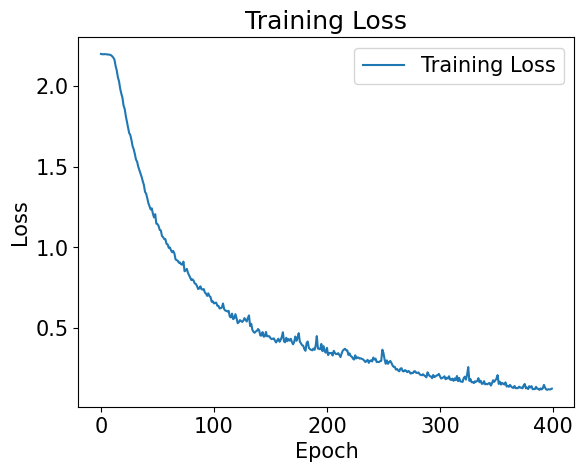

Fold 1 - Test Accuracy: 0.8757 Fold 1 - Test Weighted Accuracy: 0.8757 Test weighted F1-score (macro): 0.8767
Overall average loss: 0.4648648648648649  Average Weighted Test Accuracy: 0.8756756756756757  Average Test F1: 0.8767341358867464


In [50]:
import copy
final_model = LSTM1(num_classes, input_size, hidden_size, num_layers, output_size)

def train_full_dataset(train_dataset, model, run_id):
    # Convert data and targets into a TensorDataset
    #dataset = TensorDataset(data, targets)
    
    data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    model = LSTM1(num_classes, input_size, hidden_size, num_layers, output_size)
    optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    best_model_state = None
    losses = []

    all_losses = [[] for _ in range(fold_num)]
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        for batch_input, batch_targets in data_loader:
            optimizer.zero_grad()
            
            outputs = model(batch_input)
            loss = criterion(outputs, batch_targets)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(data_loader)
        losses.append(avg_train_loss)
        all_losses[0].append(epoch_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, Train Loss: {avg_train_loss:.5f}")
        
        if avg_train_loss < best_val_loss: # uhm this doesnt seem to be right.. shouldnt it save best model with lowest val loss not training average
            best_val_loss = avg_train_loss
            best_model_state = copy.deepcopy(model.state_dict())
    
    print(f"Training completed. Best training loss: {best_val_loss:.5f}")
    
    plt.figure()
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    plot_filename = f'graphs/plot_{run_id}_final_model.png'
    plt.savefig(plot_filename)
    plt.show()
    plt.close()
    
    torch.save(best_model_state, 'models/best_model_full_model_' + str(run_id) + '.pth')
    
    model_average_accuracy, model_weighted_accuracy, model_weighted_f1 = evaluate_model(model, val_dataset, 1)
    bundle_info(run_id, np.mean(losses), model_weighted_accuracy, model_weighted_f1, 1, all_losses, best_val_loss, 1)
    
    print(f"Overall average loss: {np.mean(model_average_loss)}", f" Average Weighted Test Accuracy: {np.mean(model_weighted_accuracy)}", f" Average Test F1: {np.mean(model_weighted_f1)}")

train_full_dataset(full_dataset, final_model, run_id)


## Model Evaluation

Here we evaluate the performance of a trained LSTM model on both the training and validation datasets. Accuracy and F1-score metrics are calculated for both datasets; training set and testing set.

This process allows for assessing how well the model performs on data it was trained on (training set) versus new, unseen data (testing set). Comparing these metrics helps identify if the model is overfitting or generalizing well to new data.


In [51]:


# Load the best model state

best_model_state = torch.load('best_full_model.pth') # from cross validation : best_model_cross_val.pth
model.load_state_dict(best_model_state)


<All keys matched successfully>

### ROC curve


In [52]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_pred_proba = []
y_true = []

# Evaluate on the test set
model.eval()
with torch.no_grad():
    val_outputs = model(val_data)
    y_pred_proba.extend(torch.softmax(val_outputs, dim=1).cpu().numpy())
    y_true.extend(val_targets.cpu().numpy())

y_pred_proba = np.array(y_pred_proba)
y_true = np.array(y_true)


NameError: name 'y_true' is not defined

In [1516]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


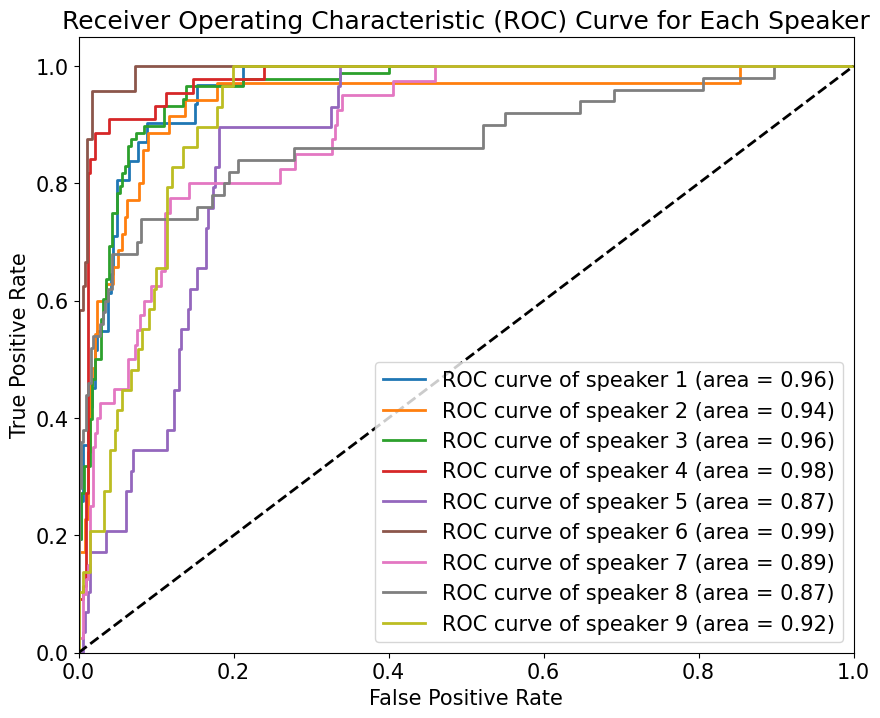

In [1517]:
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of speaker {i+1} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Speaker')
plt.legend(loc="lower right")
plot_filename = f'graphs/roc_plot_{run_id}_final_model_for_each_speaker.png'
plt.savefig(plot_filename)
plt.show()
plt.close()


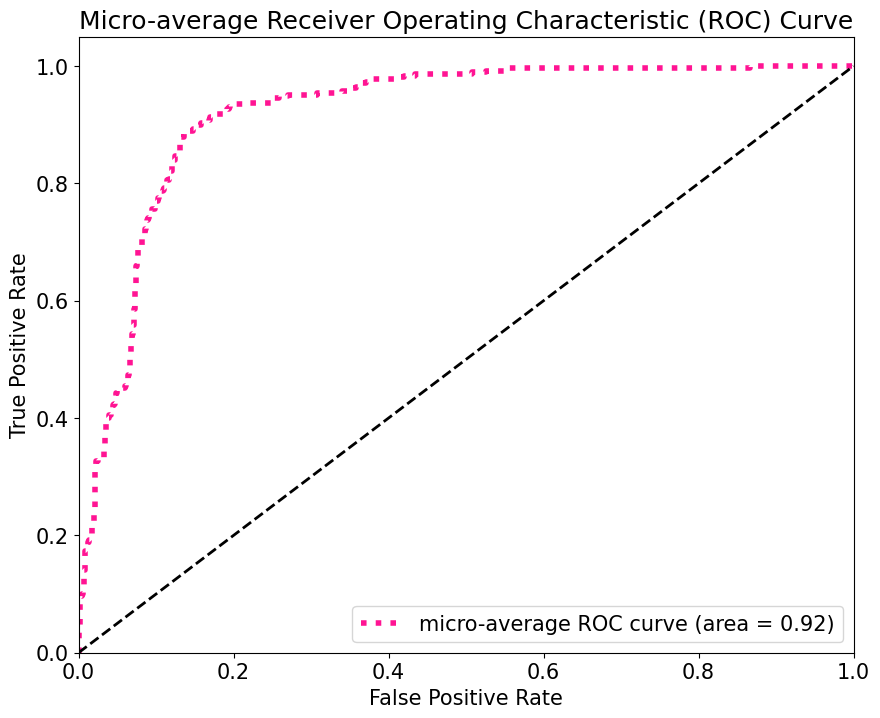

In [1518]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plot_filename = f'graphs/roc_plot_{run_id}_final_model_average.png'
plt.savefig(plot_filename)
plt.show()
plt.close()



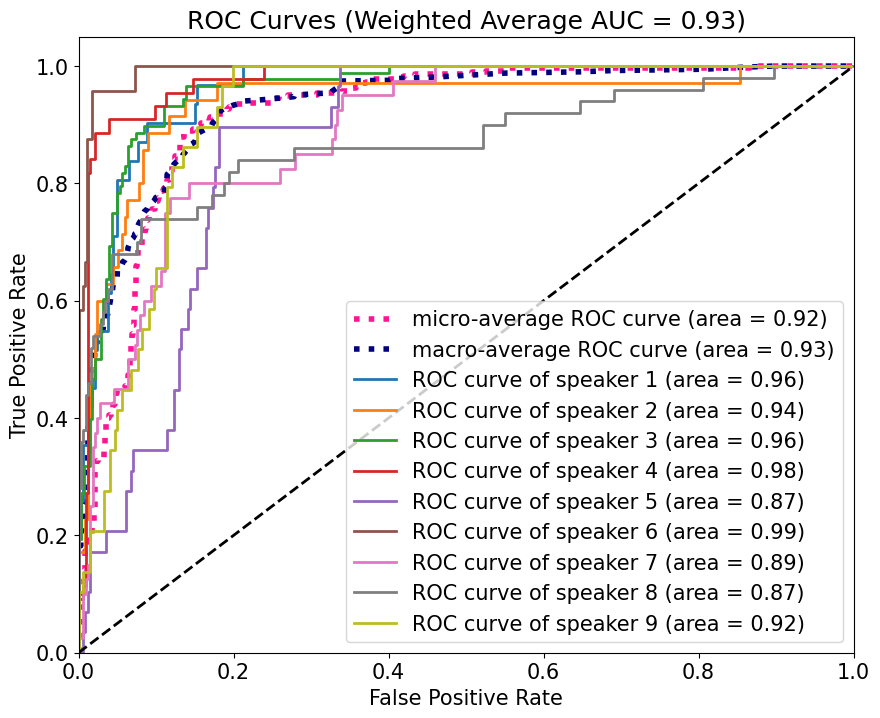

In [1519]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_pred_proba = []
y_true = []

# Evaluate on the test set
model.eval()
with torch.no_grad():
    val_outputs = model(val_data)
    y_pred_proba.extend(torch.softmax(val_outputs, dim=1).cpu().numpy())
    y_true.extend(val_targets.cpu().numpy())

y_pred_proba = np.array(y_pred_proba)
y_true = np.array(y_true)
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Compute weighted-average ROC AUC
weighted_auc = roc_auc_score(y_true_bin, y_pred_proba, average='weighted')

# Plot ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of speaker {i+1} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves (Weighted Average AUC = {weighted_auc:.2f})')
plt.legend(loc="lower right")
plot_filename = f'graphs/roc_plot_{run_id}_final_model_all_curves.png'
plt.savefig(plot_filename)
plt.show()
plt.close()


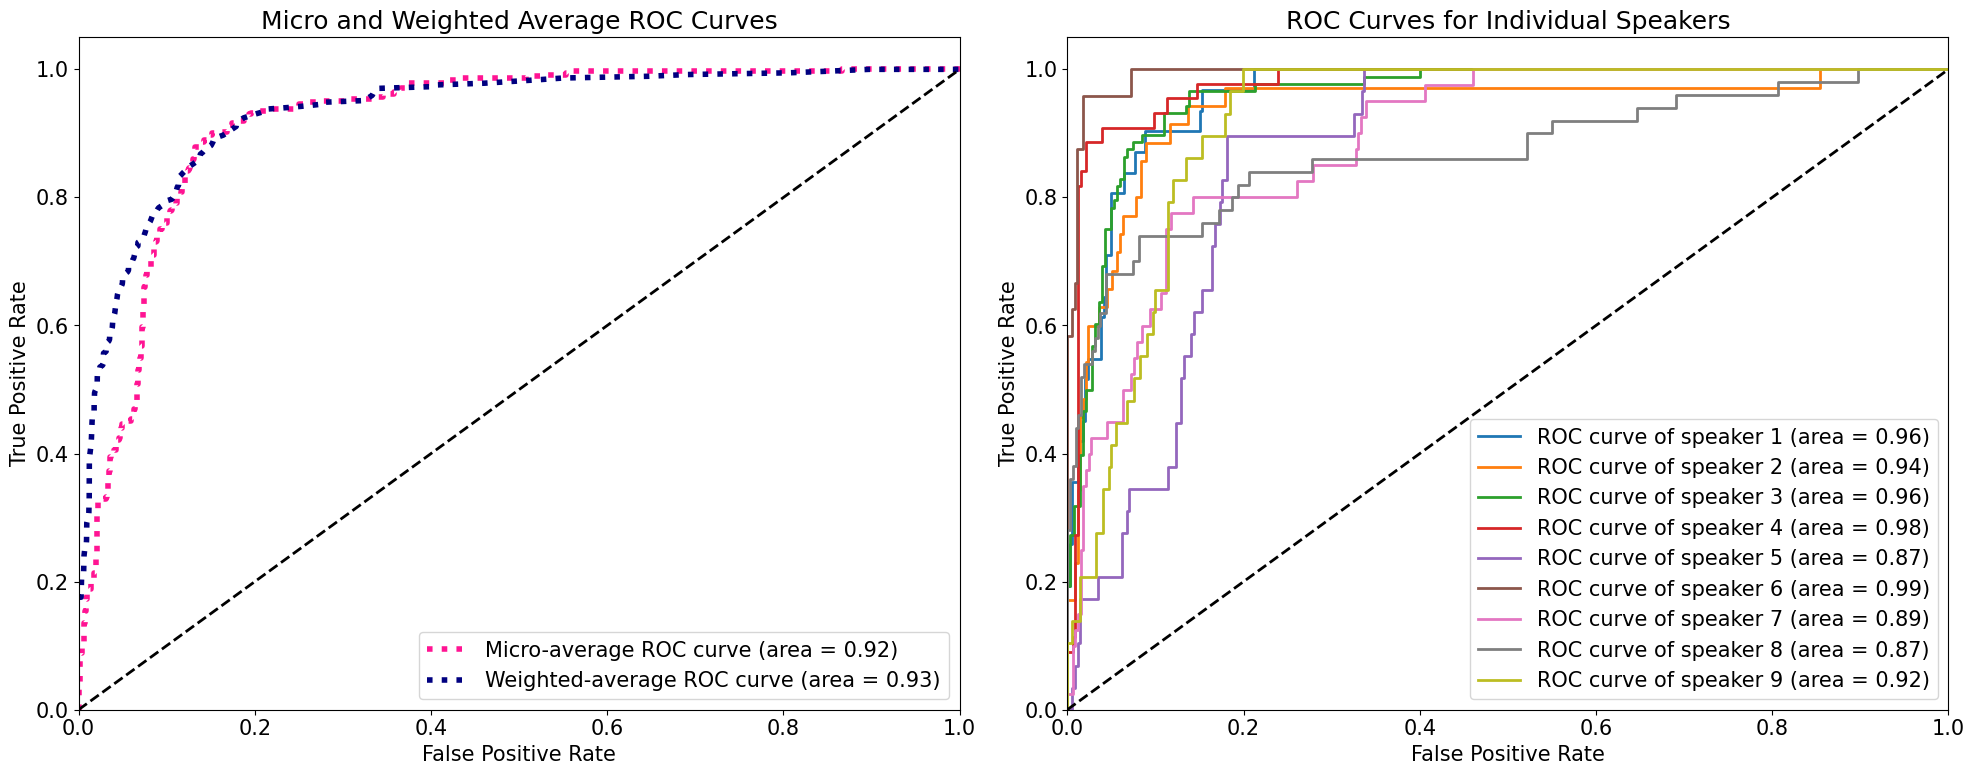

In [1520]:

y_true_bin = label_binarize(y_true, classes=range(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

# ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Get micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# get weighted-average ROC curve
weights = np.sum(y_true_bin, axis=0) / len(y_true)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
weighted_tpr = np.zeros_like(all_fpr)

plt.rcParams.update({'font.size': 15})
for i in range(num_classes):
    weighted_tpr += np.interp(all_fpr, fpr[i], tpr[i]) * weights[i]

fpr["weighted"] = all_fpr
tpr["weighted"] = weighted_tpr
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# micro-average and weighted-average ROC curves
ax1.plot(fpr["micro"], tpr["micro"], 
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)
ax1.plot(fpr["weighted"], tpr["weighted"],
         label=f'Weighted-average ROC curve (area = {roc_auc["weighted"]:.2f})',
         color='navy', linestyle=':', linewidth=4)
ax1.plot([0, 1], [0, 1], 'k--', lw=2)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Micro and Weighted Average ROC Curves')
ax1.legend(loc="lower right")

# ROC curves for each speaker
for i in range(num_classes):
    ax2.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of speaker {i+1} (area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=2)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves for Individual Speakers')
ax2.legend(loc="lower right")

plt.tight_layout()
plot_filename = f'graphs/roc_plot_{run_id}_final_model_side_by_side.png'
plt.savefig(plot_filename)
plt.show()
plt.close()
